In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as spio
import getpass
import os


In [2]:
## Variables
Blank_zone = 0.11
Vbeam = 6.32 # distance of vertical sample

C:/Users/Sjoerd Gn/Documents/Fieldwork/fieldwork-2019-adcp-adv/data/Sontek\1. Monday morning
20051002095139.mat 1
Transducerdepth:   Monday morning 20051002095139.mat 0.07
20051002095859.mat 0
Transducerdepth:   Monday morning 20051002095859.mat 0.07
20051002100742.mat 1
Transducerdepth:   Monday morning 20051002100742.mat 0.07
20051002101138.mat 0
Transducerdepth:   Monday morning 20051002101138.mat 0.07

Mean Qs 0
Mean right Q =  0.0003096332057860718 m^3/s
Mean left Q =  0.0 m^3/s
Mean top Q =  0.4411686607700176 m^3/s
Mean middle Q =  1.8412028332031791 m^3/s
Sum all 2.282990760384769
Total Q 2.0281638998179554
0

C:/Users/Sjoerd Gn/Documents/Fieldwork/fieldwork-2019-adcp-adv/data/Sontek\2. Monday afternoon
20051002153808.mat 1
Transducerdepth:  onday afternoon 20051002153808.mat 0.07
20051002154435.mat 0
Transducerdepth:  onday afternoon 20051002154435.mat 0.07
20051002155011.mat 1
Transducerdepth:  onday afternoon 20051002155011.mat 0.07
20051002160639.mat 0
Transducerdepth:  ond

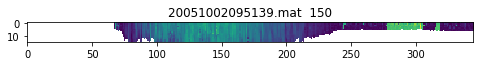

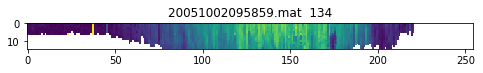

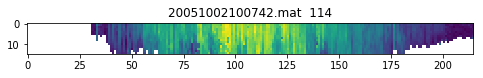

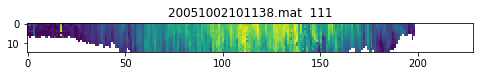

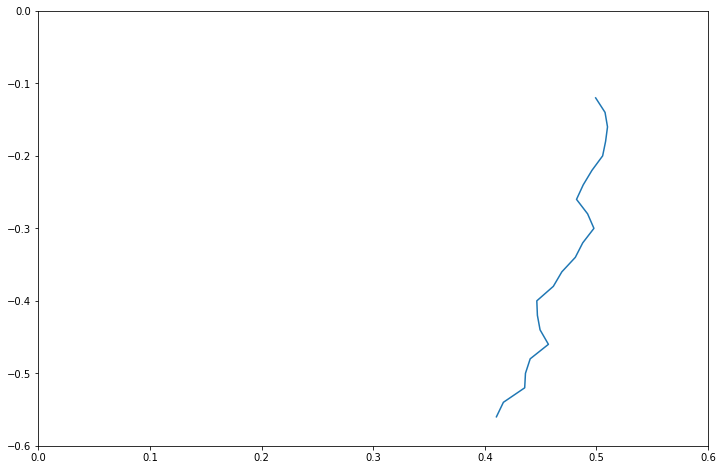

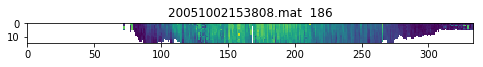

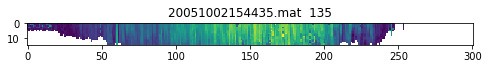

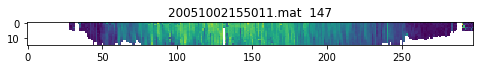

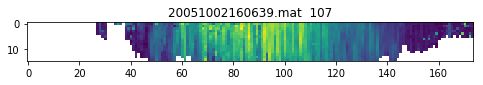

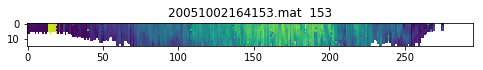

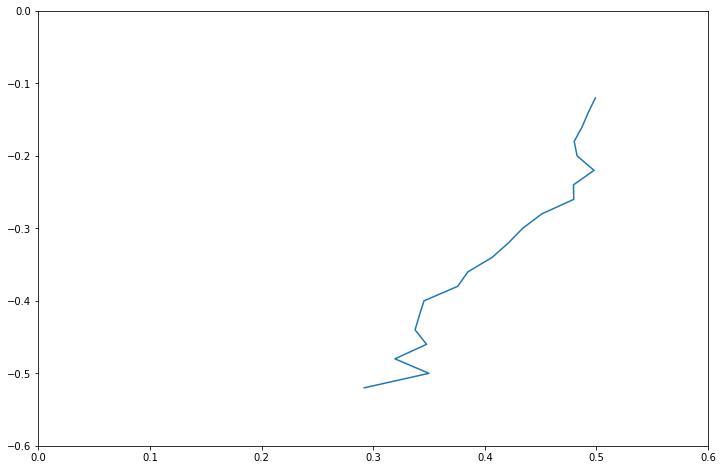

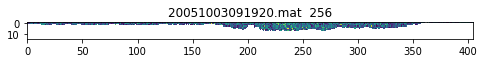

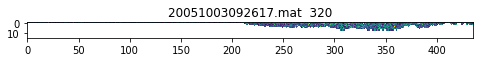

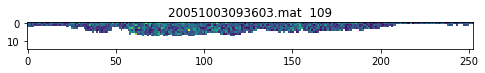

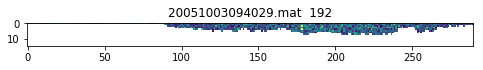

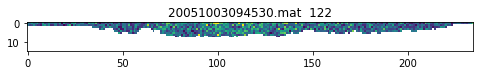

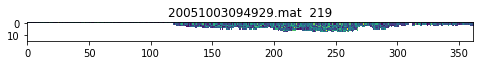

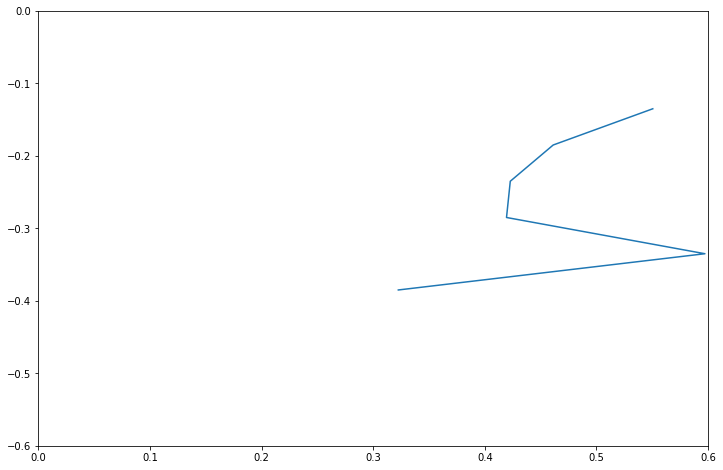

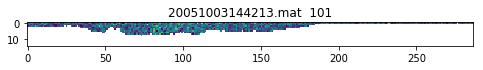

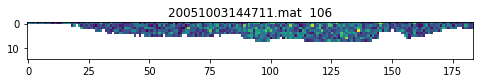

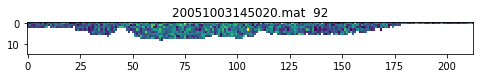

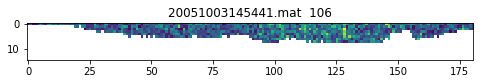

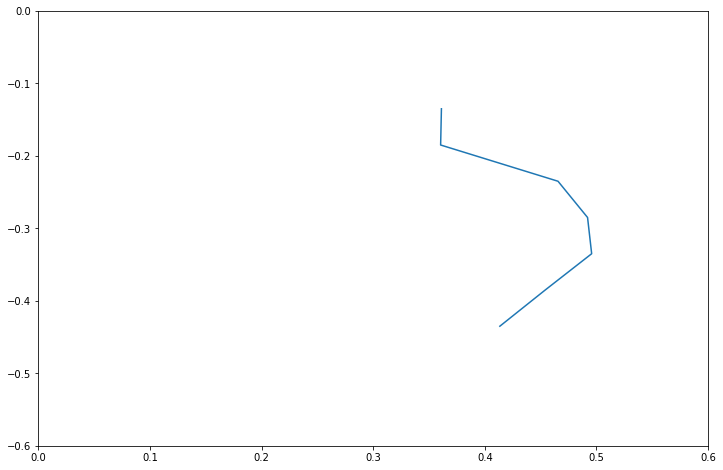

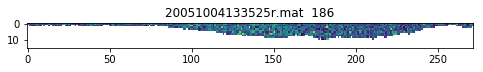

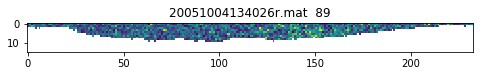

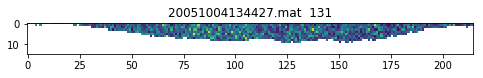

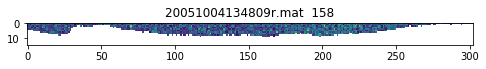

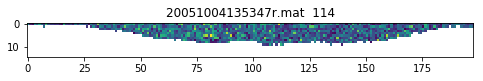

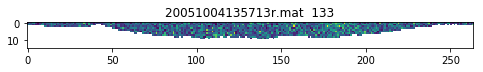

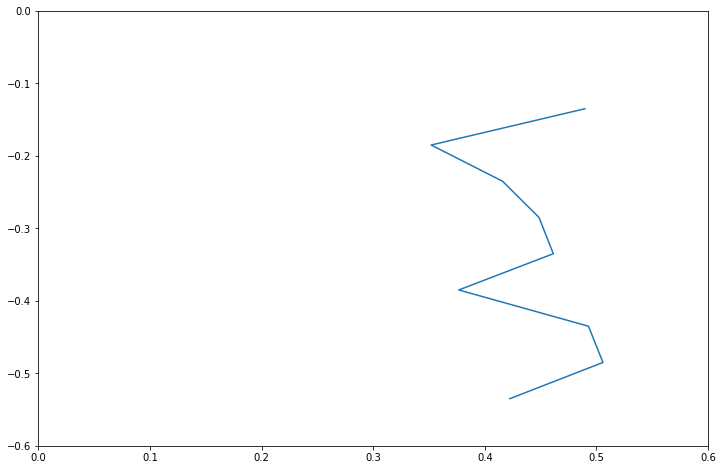

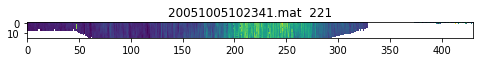

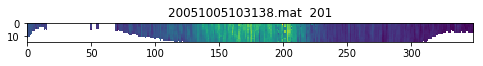

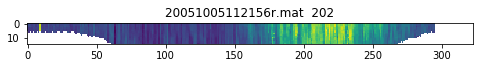

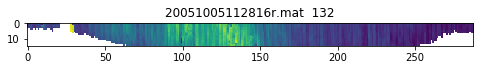

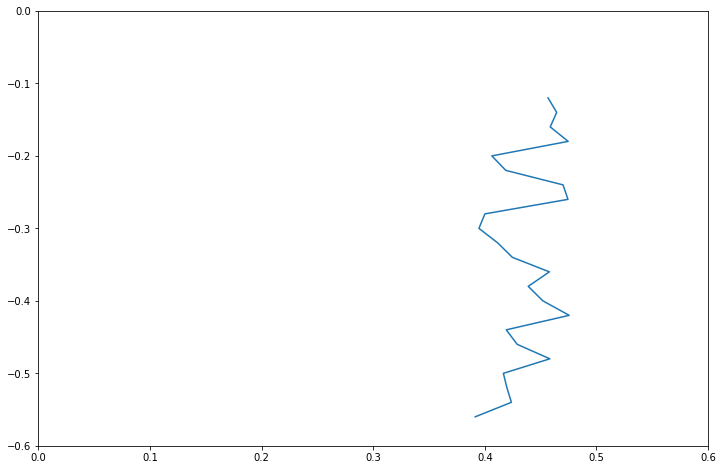

In [24]:
# Was function smartpulsehd on?
smartpulsehd = np.array([1, 1, 0, 0, 0, 1])

# Number of days in total
numdays = 6

# Name of the computer
myhost = getpass.getuser()

# Base folder
basefolder = 'C:/Users/username/Documents/Fieldwork/fieldwork-2019-adcp-adv/data/Sontek'.replace('username', myhost)# basefolder

# Four different qs per time period
allqs = [np.zeros(numdays) for i in range(4)]

# Count the number of days
day = 0

# loop over all roots
for root, dirs, files in os.walk(basefolder, topdown=False):
    
    # Don't look in the basefolder
    if root == basefolder:
        continue
        
    # which folder are we doing right now?
    print(root)
    
    # Per time period, save the number of depth cells
    tot_xs = {}
    len_xs = 1000
    
    # Files that we want to use
    goodfiles = [file for file in files if (file[-4:] == '.mat') and (file[-5:] != 'y.mat')] 
    
    # Total Qs to be saved
    tot_rightq = np.zeros(len(goodfiles))
    tot_leftq = np.zeros_like(tot_rightq)
    tot_topq = np.zeros_like(tot_rightq)
    tot_middleq = np.zeros_like(tot_rightq)
    
    filenum = 0
    
    for file in goodfiles:
        direction = int(np.loadtxt(root+'/direction.txt', delimiter = ',')[filenum])
        print(file, direction)

        
        matfile = root+'/'+file
        mat = spio.loadmat(matfile)

        Velocity    = mat['WaterTrack']['Velocity'][()][0][0]       # velocity for each of the 4 beams


        Vprofile = (Velocity[:,0,:]**2+Velocity[:,1,:]**2)**0.5  # average velocity profile
        plt.figure(figsize=(8,12))
        plt.imshow(Vprofile[:15, :])


        RightQ = mat['Summary']['Right_Q'][()][0][0][-1][0]
        LeftQ = mat['Summary']['Left_Q'][()][0][0][-1][0]
        TopQ = mat['Summary']['Top_Q'][()][0][0][-1][0]
        MiddleQ = mat['Summary']['Middle_Q'][()][0][0][-1][0]+mat['Summary']['Bottom_Q'][()][0][0][-1][0]+mat['Summary']['Top_Q'][()][0][0][-1][0]

        tot_rightq[filenum] = RightQ
        tot_leftq[filenum] = LeftQ
        tot_topq[filenum] = TopQ
        tot_middleq[filenum] = MiddleQ


        TransducerDepth = mat['Setup']['sensorDepth'][()][0][0][0][0]
        print('Transducerdepth: ', root[-15:], file, TransducerDepth)

        Vmean = mat['Summary']['Mean_Vel'][()][:,0][0][0] # = nanmean(Vprofile,1)   # average velocity averaged over the depth   


        Depth = mat['Summary']['Depth'][()][0][0] 
        Cells = (mat['Summary']['Cells'][()])[0][0]#.astype('int')                   # number of cells for each vertical beam

        Cells = np.array([int(Cells[i][0]) for i in range(len(Cells))])



        Discharge   = mat['Summary']['Total_Q'][()][0][0]     # discharge
        Track       = mat['Summary']['Track'][()][0][0]    # track location for each sample in X/Y coordinates
        #print(Track)

         # Wednesday Morning was flipped

        #plt.figure()
        Track_x = np.array([Track[i][0] for i in range(len(Track))])
        Track_y = np.array([Track[i][1] for i in range(len(Track))])
        #plt.plot(Track_x, Track_y)
        #plt.axis('equal')

        Distance = np.array([(Track_x[i]**2+Track_y[i]**2)**0.5 for i in range(len(Track_x))]) #np.sum(abs(Track),1)    #this is probably not be correct and it depends how Track is measured. Please check this!


        if direction==1:  # flip if reverse
            Distance = np.max(Distance)-Distance


        '''
        plt.figure()
        plt.plot(Distance)
        '''

        # Depth_BT    = mat['BottomTrack']['BT_Depth'][()][0][0] # bottom track (BT) depth using 4 beams at 3MHz frequency (smaller depth range, higher resolution). The depth is estimated assuming the river bed does not move and using boat movement information.
        #DepthBeam   = mat['BottomTrack']['BT_Beam_Depth'][()][0][0]                       # total water depth for each beam
        Cellsize = mat['System']['Cell_Size'][()][0][0]
        Cellsize = np.array([round(Cellsize[i][0],4) for i in range(len(Cells))])

        dist_to_vbeam = np.array([abs(Distance[i]-Vbeam) for i in range(len(Distance))])

        Vbeam_cell = np.argmin(dist_to_vbeam)

        y_axis = -Blank_zone-Cellsize[Vbeam_cell]*np.linspace(0.5, Cells[Vbeam_cell]-0.5,Cells[Vbeam_cell])
        x_axis =  Vprofile[0:Cells[Vbeam_cell], Vbeam_cell]

        # AVERAGE SIDES
        # x_axisplus1 = Vprofile[0:Cells[Vbeam_cell+1], Vbeam_cell+1]
        # x_axisminus1 = Vprofile[0:Cells[Vbeam_cell-1], Vbeam_cell-1]
        #minsides = np.min([
        #    len(x_axis), 
        #    len(x_axisplus1), 
        #    len(x_axisminus1)])

        # x_axis = np.array([(x_axis[i]*2+x_axisplus1[i]+x_axisminus1[i])/4 for i in range(minsides)])
        tot_xs[file] = x_axis

        if len(x_axis) < len_xs:
            len_xs = len(x_axis)
            tot_ys = y_axis #[0:minsides]

        '''
        plt.plot(x_axis, y_axis)
        '''

        plt.title(file+'  '+str(Vbeam_cell))


        '''
        plt.figure()
        plt.plot(-Depth, 'b')

        plt.plot(-Cellsize*np.array(Cells)-Blank_zone, 'r')
        plt.plot([0,len(Cells)], [-Blank_zone, -Blank_zone], 'r')
        plt.plot([0,len(Cells)], [0,0], 'b')
        '''
         
        filenum +=1

    #print(tot_xs)
    #print(len_xs)
    
    
    x_axis_tot = np.zeros(len_xs)
    
    for j in range(len_xs):     #depths
        level_tot = np.zeros(len(goodfiles))
        
        i = 0
        for file in goodfiles: #files
            level_tot[i] = tot_xs[file][j]
            i+=1
                
        x_axis_tot[j] = np.mean(level_tot)

    plt.figure(figsize=(12,8))
    plt.plot(x_axis_tot, tot_ys)
    plt.ylim((-.6,0))
    plt.xlim((0, 0.6))

    # Means of the Qs
    mean_rightq = np.mean(tot_rightq)
    mean_leftq = np.mean(tot_leftq)
    mean_topq = np.mean(tot_topq)
    mean_middleq = np.mean(tot_middleq)

    # Save means
    print()
    print('Mean Qs', day)
    print('Mean right Q = ', mean_rightq, 'm^3/s')
    print('Mean left Q = ', mean_leftq, 'm^3/s')
    print('Mean top Q = ', mean_topq, 'm^3/s')
    print('Mean middle Q = ', mean_middleq, 'm^3/s')
    print('Sum all', sum((mean_rightq, mean_rightq, mean_topq, mean_middleq)))
    print('Total Q', Discharge[-1][0])

    allqs[0][day] = mean_rightq
    allqs[1][day] = mean_leftq
    allqs[2][day] = mean_topq
    allqs[3][day] = mean_middleq
        
    print(day)
    print()
    day += 1


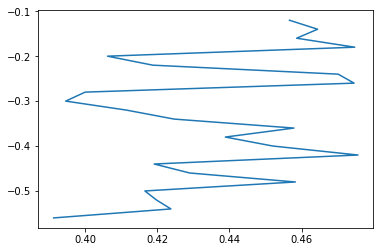

In [20]:
plt.plot(x_axis_tot, tot_ys)

In [38]:
print(allqs)

[array([0.00030963, 0.00107006, 0.00713029, 0.00526318, 0.01742396,
       0.00709698]), array([ 0.        , -0.00028964,  0.01596148,  0.0192531 ,  0.05177486,
        0.0206138 ]), array([0.44116866, 0.36076349, 0.56337136, 0.51911001, 0.62579242,
       0.42078304]), array([1.84120283, 1.70613401, 1.82914927, 1.91460315, 2.2001372 ,
       2.01287431])]


<Figure size 504x504 with 0 Axes>

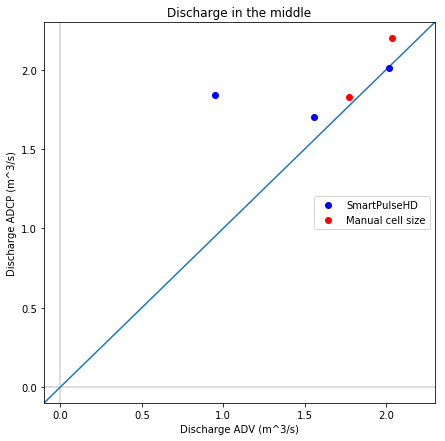

<Figure size 504x504 with 0 Axes>

In [21]:
rightadv = np.array([0.04, 0.05, 0.04, 10000,  0.07, 0.06])
leftadv = np.array([0.03, 0.03, 0.07, 10,  0.06, 0.1])
middleadv = np.array([0.95, 1.56, 1.77, 100,  2.04, 2.02])



plt.figure(figsize=(7,7))
plt.axvline(0, color='lightgray')
plt.axhline(0, color='lightgray')
plt.plot([-3, 3], [-3, 3])
plt.xlim((-.1, 2.3))
plt.ylim((-.1, 2.3))

plt.plot(middleadv[smartpulsehd==1], allqs[3][smartpulsehd==1], 'bo', label = 'SmartPulseHD')
plt.plot(middleadv[smartpulsehd==0], allqs[3][smartpulsehd==0], 'ro', label = 'Manual cell size')
plt.legend()
plt.xlabel('Discharge ADV (m^3/s)')
plt.ylabel('Discharge ADCP (m^3/s)')
plt.title('Discharge in the middle')
plt.savefig('figure1.png')

plt.figure(figsize=(7,7))


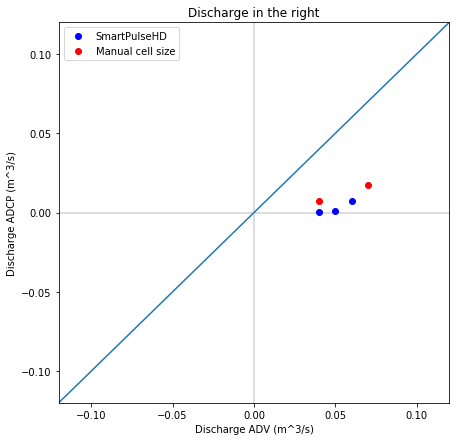

In [22]:
plt.figure(figsize=(7,7))
plt.axvline(0, color='lightgray')
plt.axhline(0, color='lightgray')
plt.plot([-3, 3], [-3, 3])

plt.xlim((-0.12, 0.12))
plt.ylim((-0.12, 0.12))

plt.plot(rightadv[smartpulsehd==1], allqs[0][smartpulsehd==1], 'bo', label = 'SmartPulseHD')
plt.plot(rightadv[smartpulsehd==0], allqs[0][smartpulsehd==0], 'ro', label = 'Manual cell size')
plt.legend()
plt.xlabel('Discharge ADV (m^3/s)')
plt.ylabel('Discharge ADCP (m^3/s)')
plt.title('Discharge in the right')
plt.savefig('figure2.png')


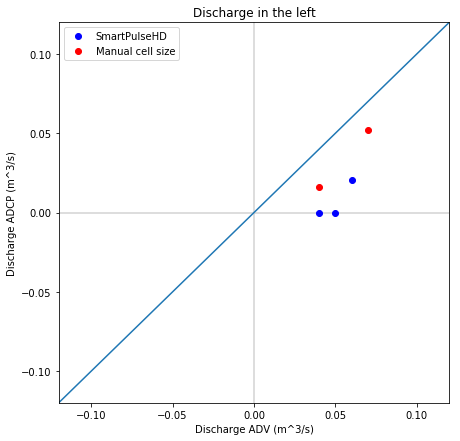

In [23]:
plt.figure(figsize=(7,7))
plt.axvline(0, color='lightgray')
plt.axhline(0, color='lightgray')
plt.plot([-3, 3], [-3, 3])
plt.xlim((-0.12, 0.12))
plt.ylim((-0.12, 0.12))

plt.plot(rightadv[smartpulsehd==1], allqs[1][smartpulsehd==1], 'bo', label = 'SmartPulseHD')
plt.plot(rightadv[smartpulsehd==0], allqs[1][smartpulsehd==0], 'ro', label = 'Manual cell size')
plt.legend()
plt.xlabel('Discharge ADV (m^3/s)')
plt.ylabel('Discharge ADCP (m^3/s)')
plt.title('Discharge in the left')
plt.savefig('figure3.png')

In [25]:
# get depths

test
